##### Image Classification: HOG vs LBP with SVM
# ⚠️This notebook works BOTH in Google Colab and locally

In [1]:
# Cell 1: Environment Setup
import os
import sys

def setup_environment():
    """Setup environment and paths automatically"""
    
    # Check if running in Google Colab
    if 'google.colab' in sys.modules:
        print("🔧 Environment: Google Colab")
        
        # Install required packages
        !pip install opendatasets scikit-image seaborn joblib -q
        
        # Mount Google Drive
        from google.colab import drive
        drive.mount('/content/drive')
        
        dataset_path = '/content/drive/MyDrive/ML/hog_lbp_Dataset'
        
    else:
        print("🔧 Environment: Local (VS Code / Jupyter)")
        dataset_path = '../data/raw'
    
    # Check if dataset exists
    if os.path.exists(dataset_path):
        print(f"✅ Dataset found at: {dataset_path}")
    else:
        print(f"⚠️  Dataset NOT found at: {dataset_path}")
        print("\n📥 To download the dataset:")
        print("   1. Visit: https://drive.google.com/drive/folders/1cXLRw66bPsqLzqptwTqUfXlwM-bBUb7I?usp=sharing")
        print("   2. Download 'hog_lbp_Dataset' folder")
        print("   3. Extract to 'data/raw/' in this project")
        print("\n   Expected structure:")
        print("   data/raw/train/{city,face,green,office,sea}/")
        print("   data/raw/test/{city,face,green,office,sea}/")
    
    return dataset_path

# Run setup
DATASET_PATH = setup_environment()

🔧 Environment: Local (VS Code / Jupyter)
✅ Dataset found at: ../data/raw


In [2]:
# Cell 2: IMPORTS (SAME AS YOUR ORIGINAL)
import numpy as np
import cv2
from skimage import feature
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import seaborn as sns
from tqdm import tqdm
import joblib
import pandas as pd

print("✅ All imports successful!")

✅ All imports successful!


In [3]:
# Cell 3: CONFIGURATION CLASS (MODIFIED)
class Config:
    """Configuration for the project - uses auto-detected path"""
    
    # Use the auto-detected path
    DATASET_PATH = DATASET_PATH
    
    # HOG parameters
    HOG_ORIENTATIONS = 9
    HOG_PIXELS_PER_CELL = (8, 8)
    HOG_CELLS_PER_BLOCK = (2, 2)
    
    # LBP parameters
    LBP_RADIUS = 3
    LBP_N_POINTS = 24
    LBP_METHOD = 'uniform'
    
    # SVM parameters
    SVM_C = 1.0
    SVM_KERNEL = 'rbf'
    SVM_GAMMA = 'scale'
    
    # Cross-validation
    K_FOLDS = 5
    RANDOM_STATE = 42
    
    # Image size for resizing
    IMG_SIZE = (128, 128)

config = Config()

### The next cells are the same as the original colab notebook

In [4]:
# DATA LOADER CLASS
class DataLoader:
    def __init__(self, config):
        self.config = config
        self.classes = ['city', 'face', 'green', 'office', 'sea']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.idx_to_class = {idx: cls for idx, cls in enumerate(self.classes)}

    def load_images_from_folder(self, folder_path):
        """Load images from a specific folder"""
        images = []
        labels = []

        for class_name in self.classes:
            class_path = os.path.join(folder_path, class_name)
            if not os.path.exists(class_path):
                print(f"⚠️ Warning: {class_path} does not exist")
                continue

            print(f"📁 Loading {class_name} images...")
            class_images = []
            for img_file in tqdm(os.listdir(class_path)):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_path, img_file)
                    try:
                        # Read image
                        img = cv2.imread(img_path)
                        if img is not None:
                            # Resize and convert color format
                            img = cv2.resize(img, self.config.IMG_SIZE)
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                            class_images.append(img)
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")

            images.extend(class_images)
            labels.extend([self.class_to_idx[class_name]] * len(class_images))
            print(f"✅ Loaded {len(class_images)} {class_name} images")

        return np.array(images), np.array(labels)

    def load_dataset(self):
        """Load both train and test datasets"""
        train_path = os.path.join(self.config.DATASET_PATH, 'train')
        test_path = os.path.join(self.config.DATASET_PATH, 'test')

        print("🚀 Loading training dataset...")
        X_train, y_train = self.load_images_from_folder(train_path)

        print("🚀 Loading test dataset...")
        X_test, y_test = self.load_images_from_folder(test_path)

        print(f"\n📊 Dataset Summary:")
        print(f"Training set: {X_train.shape[0]} images")
        print(f"Test set: {X_test.shape[0]} images")
        print(f"Image shape: {X_train[0].shape}")
        print(f"Classes: {self.classes}")

        return X_train, X_test, y_train, y_test

# Initialize data loader
data_loader = DataLoader(config)

In [5]:
# Load the dataset
X_train, X_test, y_train, y_test = data_loader.load_dataset()
# Display dataset information
print(f"📈 Training data shape: {X_train.shape}")
print(f"📈 Test data shape: {X_test.shape}")
print(f"🎯 Training labels distribution: {np.unique(y_train, return_counts=True)}")
print(f"🎯 Test labels distribution: {np.unique(y_test, return_counts=True)}")

🚀 Loading training dataset...
📁 Loading city images...


100%|██████████| 140/140 [00:02<00:00, 61.93it/s]


✅ Loaded 140 city images
📁 Loading face images...


100%|██████████| 133/133 [00:01<00:00, 81.65it/s] 


✅ Loaded 133 face images
📁 Loading green images...


100%|██████████| 133/133 [00:01<00:00, 71.57it/s]


✅ Loaded 133 green images
📁 Loading office images...


100%|██████████| 140/140 [00:01<00:00, 84.33it/s] 


✅ Loaded 140 office images
📁 Loading sea images...


100%|██████████| 142/142 [00:03<00:00, 39.91it/s]


✅ Loaded 142 sea images
🚀 Loading test dataset...
📁 Loading city images...


100%|██████████| 30/30 [00:00<00:00, 36.98it/s]


✅ Loaded 30 city images
📁 Loading face images...


100%|██████████| 30/30 [00:00<00:00, 53.32it/s]


✅ Loaded 30 face images
📁 Loading green images...


100%|██████████| 30/30 [00:00<00:00, 55.48it/s]


✅ Loaded 30 green images
📁 Loading office images...


100%|██████████| 30/30 [00:02<00:00, 14.88it/s]


✅ Loaded 30 office images
📁 Loading sea images...


100%|██████████| 30/30 [00:03<00:00,  8.63it/s]

✅ Loaded 30 sea images

📊 Dataset Summary:
Training set: 688 images
Test set: 150 images
Image shape: (128, 128, 3)
Classes: ['city', 'face', 'green', 'office', 'sea']
📈 Training data shape: (688, 128, 128, 3)
📈 Test data shape: (150, 128, 128, 3)
🎯 Training labels distribution: (array([0, 1, 2, 3, 4]), array([140, 133, 133, 140, 142], dtype=int64))
🎯 Test labels distribution: (array([0, 1, 2, 3, 4]), array([30, 30, 30, 30, 30], dtype=int64))


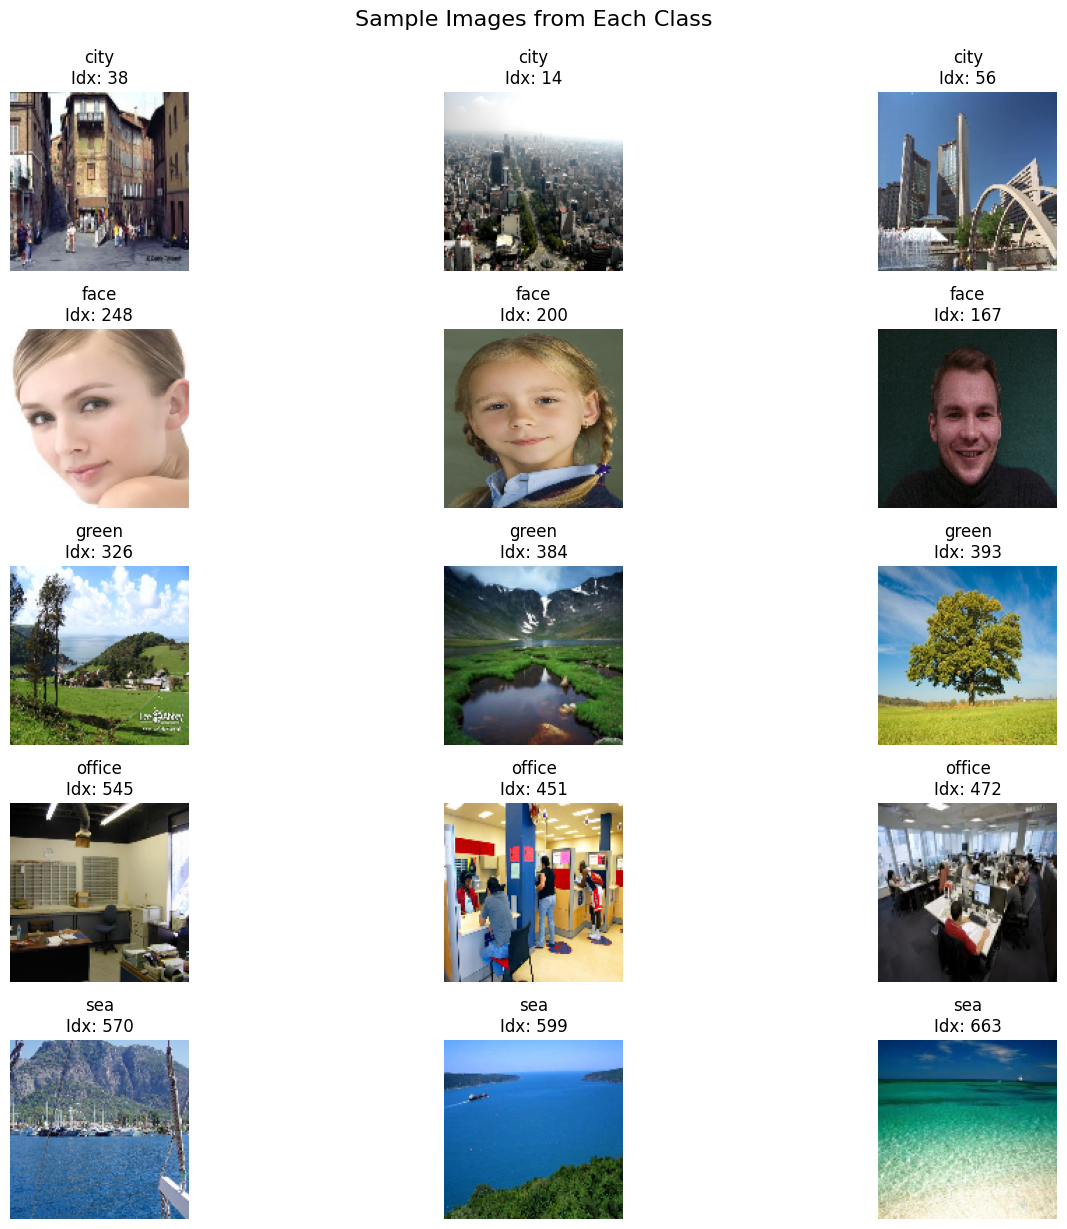

In [6]:
# Visualize some sample images from each class
def plot_sample_images(images, labels, num_samples=3):
    fig, axes = plt.subplots(len(data_loader.classes), num_samples, figsize=(15, 12))

    for class_idx, class_name in enumerate(data_loader.classes):
        # Get indices of current class
        class_indices = np.where(labels == class_idx)[0]

        # Select random samples
        if len(class_indices) > 0:
            sample_indices = np.random.choice(class_indices, num_samples, replace=False)

            for i, idx in enumerate(sample_indices):
                axes[class_idx, i].imshow(images[idx])
                axes[class_idx, i].set_title(f'{class_name}\nIdx: {idx}')
                axes[class_idx, i].axis('off')
        else:
            for i in range(num_samples):
                axes[class_idx, i].axis('off')
                axes[class_idx, i].set_title(f'{class_name}\nNo images')

    plt.tight_layout()
    plt.suptitle('Sample Images from Each Class', fontsize=16, y=1.02)
    plt.show()

plot_sample_images(X_train, y_train)

In [7]:
# FEATURE EXTRACTION CLASSES

class FeatureExtractor:
    def __init__(self, config):
        self.config = config

    def extract_hog_features(self, images):
        """Extract HOG features from images"""
        hog_features = []
        hog_images = []

        print("🔍 Extracting HOG features...")
        for img in tqdm(images):
            # Convert to grayscale for HOG
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

            # Extract HOG features and visualization
            features, hog_image = feature.hog(
                gray,
                orientations=self.config.HOG_ORIENTATIONS,
                pixels_per_cell=self.config.HOG_PIXELS_PER_CELL,
                cells_per_block=self.config.HOG_CELLS_PER_BLOCK,
                visualize=True,
                block_norm='L2-Hys'
            )

            hog_features.append(features)
            hog_images.append(hog_image)

        return np.array(hog_features), hog_images

    def extract_lbp_features(self, images):
        """Extract LBP features from RGB images"""
        lbp_features = []
        lbp_images = []

        print("🔍 Extracting LBP features...")
        for img in tqdm(images):
            # Extract LBP for each channel and concatenate
            channel_features = []
            channel_lbp_images = []

            for channel in range(3):
                channel_img = img[:, :, channel]

                # Compute LBP
                lbp = local_binary_pattern(
                    channel_img,
                    self.config.LBP_N_POINTS,
                    self.config.LBP_RADIUS,
                    method=self.config.LBP_METHOD
                )

                # Compute histogram
                n_bins = self.config.LBP_N_POINTS + 2
                hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))

                # Normalize histogram
                hist = hist.astype("float")
                hist /= (hist.sum() + 1e-6)  # Avoid division by zero

                channel_features.extend(hist)
                channel_lbp_images.append(lbp)

            lbp_features.append(channel_features)
            lbp_images.append(channel_lbp_images)

        return np.array(lbp_features), lbp_images

# Initialize feature extractor
feature_extractor = FeatureExtractor(config)

In [8]:
# EXTRACT FEATURES

# Extract HOG features
X_train_hog, hog_train_vis = feature_extractor.extract_hog_features(X_train)
X_test_hog, hog_test_vis = feature_extractor.extract_hog_features(X_test)

# Extract LBP features
X_train_lbp, lbp_train_vis = feature_extractor.extract_lbp_features(X_train)
X_test_lbp, lbp_test_vis = feature_extractor.extract_lbp_features(X_test)

print(f"\n📊 Feature Extraction Complete:")
print(f"HOG features - Train: {X_train_hog.shape}, Test: {X_test_hog.shape}")
print(f"LBP features - Train: {X_train_lbp.shape}, Test: {X_test_lbp.shape}")

🔍 Extracting HOG features...


100%|██████████| 688/688 [02:15<00:00,  5.07it/s]


🔍 Extracting HOG features...


100%|██████████| 150/150 [00:18<00:00,  8.19it/s]


🔍 Extracting LBP features...


100%|██████████| 688/688 [00:33<00:00, 20.61it/s]


🔍 Extracting LBP features...


100%|██████████| 150/150 [00:07<00:00, 18.91it/s]


📊 Feature Extraction Complete:
HOG features - Train: (688, 8100), Test: (150, 8100)
LBP features - Train: (688, 78), Test: (150, 78)


🖼️ Visualizing HOG Features...


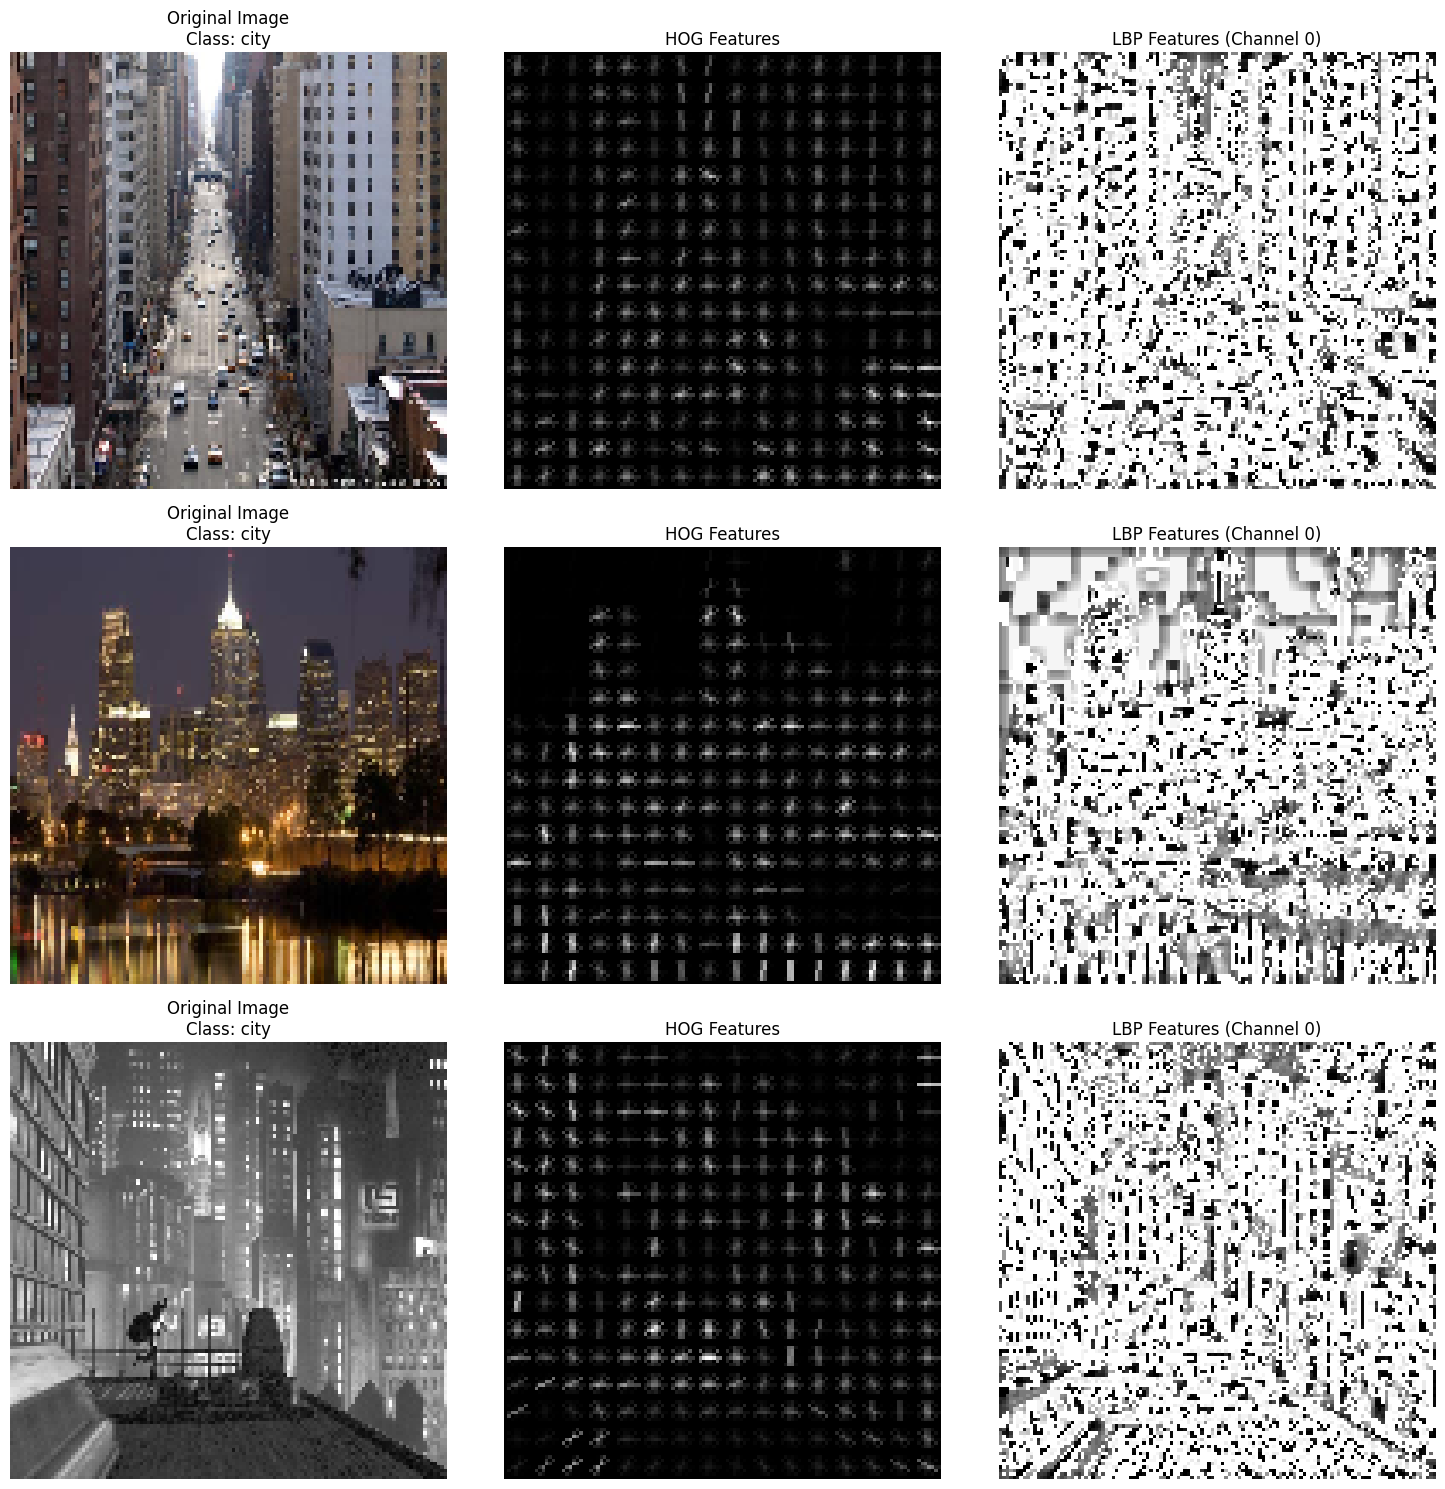

In [9]:
# =============================================================================
# VISUALIZE FEATURES
# =============================================================================

def visualize_features(original_images, hog_images, lbp_images, num_examples=3):
    """Visualize original images with HOG and LBP features"""

    # HOG Visualization
    print("🖼️ Visualizing HOG Features...")
    fig, axes = plt.subplots(num_examples, 3, figsize=(15, 5*num_examples))

    for i in range(num_examples):
        # Original image
        axes[i, 0].imshow(original_images[i])
        axes[i, 0].set_title(f'Original Image\nClass: {data_loader.idx_to_class[y_train[i]]}')
        axes[i, 0].axis('off')

        # HOG image
        axes[i, 1].imshow(hog_images[i], cmap='gray')
        axes[i, 1].set_title('HOG Features')
        axes[i, 1].axis('off')

        # LBP visualization (first channel)
        axes[i, 2].imshow(lbp_images[i][0], cmap='gray')
        axes[i, 2].set_title('LBP Features (Channel 0)')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.savefig('../results/plots/feature_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualize features
visualize_features(X_train, hog_train_vis, lbp_train_vis)

In [ ]:
# MODEL TRAINING AND EVALUATION CLASS

class ModelTrainer:
    def __init__(self, config, data_loader):
        self.config = config
        self.data_loader = data_loader

    def train_svm_model(self, X_train, X_test, y_train, y_test, feature_name):
        """Train and evaluate SVM model"""
        print(f"\n{'='*60}")
        print(f"🚀 Training SVM with {feature_name} features")
        print(f"{'='*60}")

        # Create SVM pipeline with standardization
        svm_pipeline = make_pipeline(
            StandardScaler(),
            SVC(
                C=self.config.SVM_C,
                kernel=self.config.SVM_KERNEL,
                gamma=self.config.SVM_GAMMA,
                random_state=self.config.RANDOM_STATE,
                probability=True
            )
        )

        # Cross-validation
        print("📊 Performing cross-validation...")
        kfold = KFold(n_splits=self.config.K_FOLDS, shuffle=True, random_state=self.config.RANDOM_STATE)
        cv_scores = cross_val_score(svm_pipeline, X_train, y_train, cv=kfold, scoring='accuracy')

        print(f"📈 Cross-validation scores: {cv_scores}")
        print(f"📈 Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

        # Train final model on entire training set
        print("🎯 Training final model...")
        svm_pipeline.fit(X_train, y_train)

        # Predictions
        y_pred = svm_pipeline.predict(X_test)
        y_pred_proba = svm_pipeline.predict_proba(X_test)

        # Evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, target_names=self.data_loader.classes, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)

        print(f"\n✅ Test Accuracy: {accuracy:.4f}")
        print("\n📋 Classification Report:")
        print(classification_report(y_test, y_pred, target_names=self.data_loader.classes))

        return {
            'model': svm_pipeline,
            'accuracy': accuracy,
            'precision': report['weighted avg']['precision'],
            'recall': report['weighted avg']['recall'],
            'f1': report['weighted avg']['f1-score'],
            'confusion_matrix': cm,
            'cv_scores': cv_scores,
            'feature_name': feature_name,

        }

    def plot_confusion_matrix(self, cm, title):
        """Plot confusion matrix"""
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.data_loader.classes,
                   yticklabels=self.data_loader.classes)
        plt.title(f'Confusion Matrix - {title}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig(f'../results/plots/confusion_Matrix_{title}.png', dpi=300, bbox_inches='tight')
        plt.show()

# Initialize model trainer
model_trainer = ModelTrainer(config, data_loader)


🚀 Training SVM with HOG features
📊 Performing cross-validation...
📈 Cross-validation scores: [0.86231884 0.83333333 0.88405797 0.86861314 0.83211679]
📈 Mean CV accuracy: 0.8561 (+/- 0.0407)
🎯 Training final model...

✅ Test Accuracy: 0.7867

📋 Classification Report:
              precision    recall  f1-score   support

        city       0.91      0.67      0.77        30
        face       0.97      0.93      0.95        30
       green       0.55      0.80      0.65        30
      office       0.97      0.93      0.95        30
         sea       0.69      0.60      0.64        30

    accuracy                           0.79       150
   macro avg       0.82      0.79      0.79       150
weighted avg       0.82      0.79      0.79       150



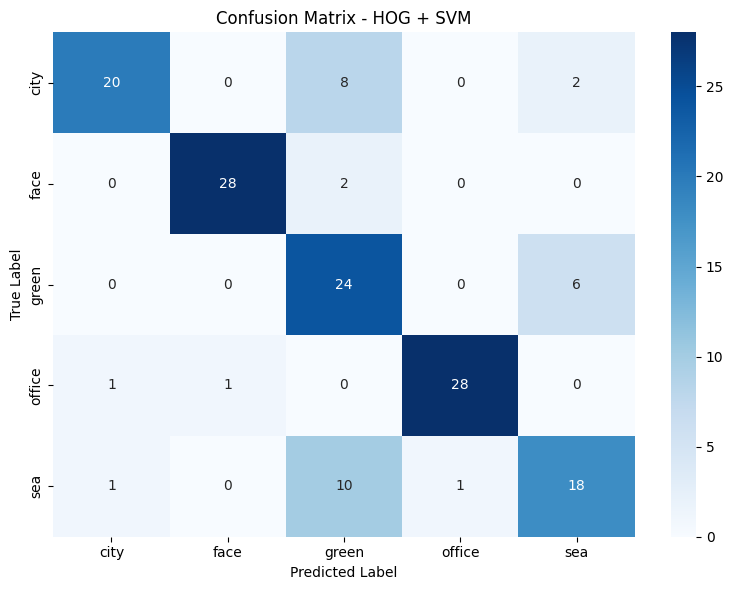

In [11]:
# TRAIN AND EVALUATE HOG + SVM

# Train HOG + SVM model
hog_results = model_trainer.train_svm_model(
    X_train_hog, X_test_hog, y_train, y_test, "HOG"
)

# Plot confusion matrix for HOG
model_trainer.plot_confusion_matrix(hog_results['confusion_matrix'], "HOG + SVM")



🚀 Training SVM with LBP features
📊 Performing cross-validation...
📈 Cross-validation scores: [0.76086957 0.6884058  0.66666667 0.7080292  0.70072993]
📈 Mean CV accuracy: 0.7049 (+/- 0.0626)
🎯 Training final model...

✅ Test Accuracy: 0.7000

📋 Classification Report:
              precision    recall  f1-score   support

        city       0.54      0.83      0.66        30
        face       0.90      0.60      0.72        30
       green       0.86      0.63      0.73        30
      office       0.76      0.83      0.79        30
         sea       0.62      0.60      0.61        30

    accuracy                           0.70       150
   macro avg       0.74      0.70      0.70       150
weighted avg       0.74      0.70      0.70       150



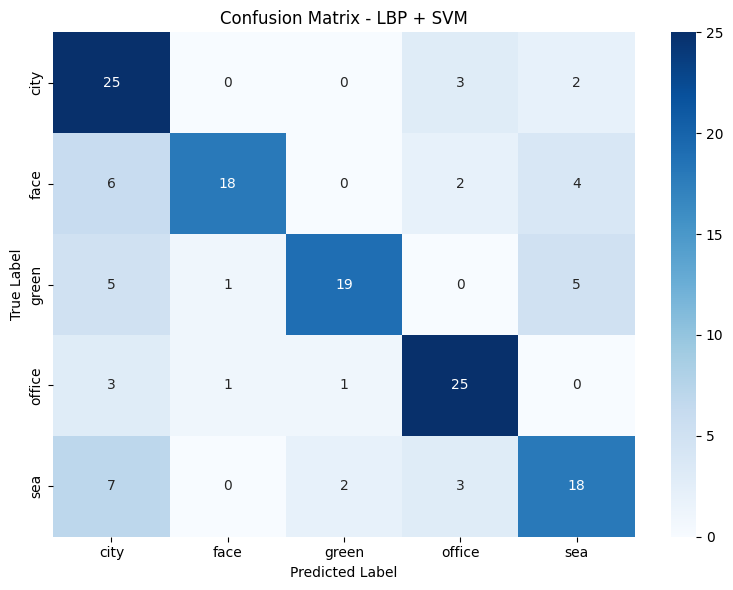

In [12]:
# TRAIN AND EVALUATE LBP + SVM

# Train LBP + SVM model
lbp_results = model_trainer.train_svm_model(
    X_train_lbp, X_test_lbp, y_train, y_test, "LBP"
)

# Plot confusion matrix for LBP
model_trainer.plot_confusion_matrix(lbp_results['confusion_matrix'], "LBP + SVM")


In [13]:
# Save HOG model
joblib.dump(hog_results['model'], '../results/models/hog_svm_model.pkl')
print("💾 HOG + SVM model saved as 'hog_svm_model.pkl'")


# Save LBP model
joblib.dump(lbp_results['model'], '../results/models/lbp_svm_model.pkl')
print("💾 LBP + SVM model saved as 'lbp_svm_model.pkl'")

💾 HOG + SVM model saved as 'hog_svm_model.pkl'
💾 LBP + SVM model saved as 'lbp_svm_model.pkl'



📊 PERFORMANCE COMPARISON: HOG vs LBP
   Metric  HOG+SVM  LBP+SVM
 Accuracy   0.7867   0.7000
Precision   0.8156   0.7371
   Recall   0.7867   0.7000
 F1-Score   0.7918   0.7025
  CV Mean   0.8561   0.7049
   CV Std   0.0203   0.0313


C:\Users\GEEK\AppData\Local\Temp\ipykernel_4584\1537728825.py:76: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[1].boxplot(cv_data, labels=['HOG+SVM', 'LBP+SVM'])


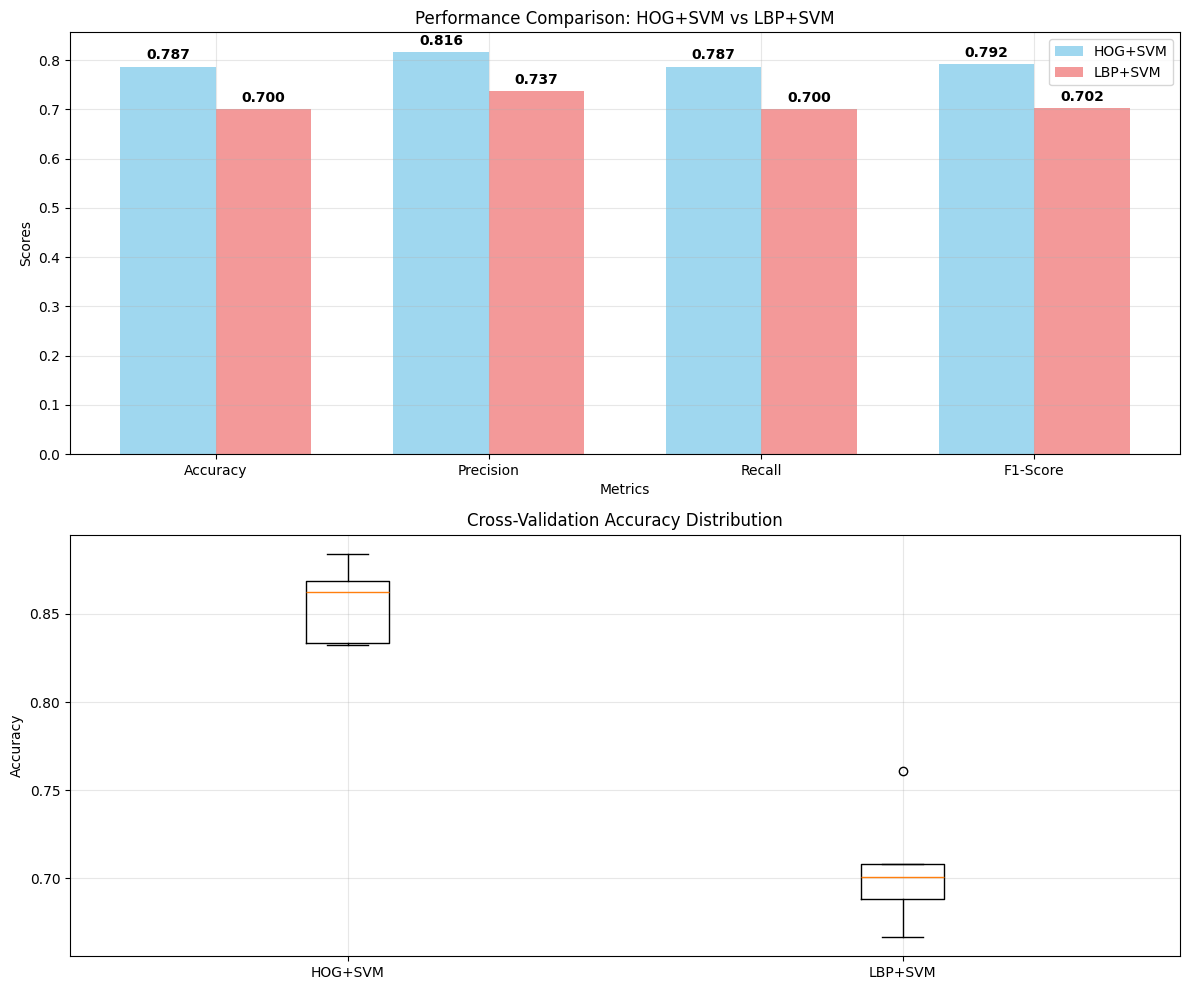


🎯 BEST PERFORMING METHOD: HOG+SVM
📈 Improvement over LBP+SVM: 0.0867 (8.67%)


In [14]:
# COMPARISON AND RESULTS VISUALIZATION

def compare_results(hog_results, lbp_results):
    """Compare HOG and LBP performance"""
    print(f"\n{'='*60}")
    print("📊 PERFORMANCE COMPARISON: HOG vs LBP")
    print(f"{'='*60}")

    # Create comparison table
    comparison_data = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'CV Mean', 'CV Std'],
        'HOG+SVM': [
            hog_results['accuracy'],
            hog_results['precision'],
            hog_results['recall'],
            hog_results['f1'],
            hog_results['cv_scores'].mean(),
            hog_results['cv_scores'].std()
        ],
        'LBP+SVM': [
            lbp_results['accuracy'],
            lbp_results['precision'],
            lbp_results['recall'],
            lbp_results['f1'],
            lbp_results['cv_scores'].mean(),
            lbp_results['cv_scores'].std()
        ]
    }

    df_comparison = pd.DataFrame(comparison_data)
    print(df_comparison.round(4).to_string(index=False))

    # Visual comparison
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    hog_values = [hog_results['accuracy'], hog_results['precision'],
                 hog_results['recall'], hog_results['f1']]
    lbp_values = [lbp_results['accuracy'], lbp_results['precision'],
                 lbp_results['recall'], lbp_results['f1']]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(2, 1, figsize=(12, 10))

    # Bar chart comparison
    bars1 = ax[0].bar(x - width/2, hog_values, width, label='HOG+SVM', alpha=0.8, color='skyblue')
    bars2 = ax[0].bar(x + width/2, lbp_values, width, label='LBP+SVM', alpha=0.8, color='lightcoral')

    ax[0].set_xlabel('Metrics')
    ax[0].set_ylabel('Scores')
    ax[0].set_title('Performance Comparison: HOG+SVM vs LBP+SVM')
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(metrics)
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax[0].annotate(f'{height:.3f}',
                      xy=(bar.get_x() + bar.get_width() / 2, height),
                      xytext=(0, 3),
                      textcoords="offset points",
                      ha='center', va='bottom', fontweight='bold')

    for bar in bars2:
        height = bar.get_height()
        ax[0].annotate(f'{height:.3f}',
                      xy=(bar.get_x() + bar.get_width() / 2, height),
                      xytext=(0, 3),
                      textcoords="offset points",
                      ha='center', va='bottom', fontweight='bold')

    # Cross-validation comparison
    cv_data = [hog_results['cv_scores'], lbp_results['cv_scores']]
    ax[1].boxplot(cv_data, labels=['HOG+SVM', 'LBP+SVM'])
    ax[1].set_title('Cross-Validation Accuracy Distribution')
    ax[1].set_ylabel('Accuracy')
    ax[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('../results/plots/PerformanceComparison_CrossValidation.png', dpi=300, bbox_inches='tight')

    plt.show()

    # Determine best method
    if hog_results['accuracy'] > lbp_results['accuracy']:
        best_method = "HOG+SVM"
        improvement = hog_results['accuracy'] - lbp_results['accuracy']
        print(f"\n🎯 BEST PERFORMING METHOD: {best_method}")
        print(f"📈 Improvement over LBP+SVM: {improvement:.4f} ({improvement*100:.2f}%)")
    else:
        best_method = "LBP+SVM"
        improvement = lbp_results['accuracy'] - hog_results['accuracy']
        print(f"\n🎯 BEST PERFORMING METHOD: {best_method}")
        print(f"📈 Improvement over HOG+SVM: {improvement:.4f} ({improvement*100:.2f}%)")

    return df_comparison

# Perform comparison
df_comparison = compare_results(hog_results, lbp_results)

💾 Complete results saved as 'classification_results.pkl'


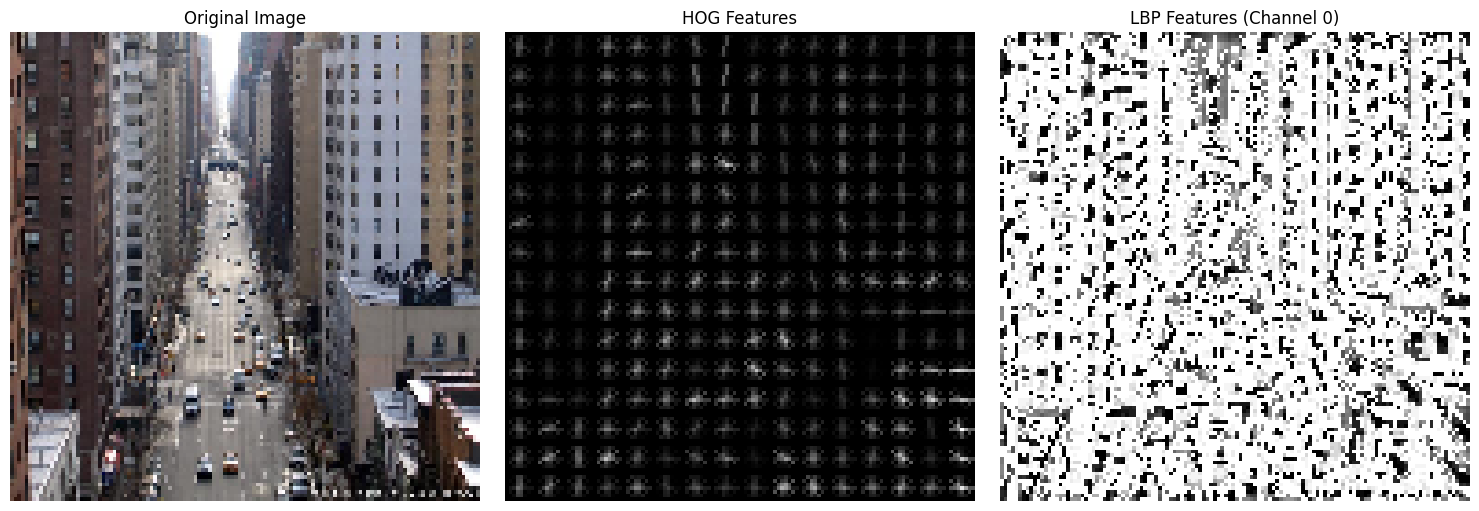

💾 Feature visualization saved as 'feature_visualization.png'


In [15]:
# SAVE RESULTS AND GENERATE FINAL REPORT

# Save all results
results = {
    'hog_results': hog_results,
    'lbp_results': lbp_results,
    'comparison': df_comparison.to_dict(),
    'config': {
        'hog_orientations': config.HOG_ORIENTATIONS,
        'hog_pixels_per_cell': config.HOG_PIXELS_PER_CELL,
        'hog_cells_per_block': config.HOG_CELLS_PER_BLOCK,
        'lbp_radius': config.LBP_RADIUS,
        'lbp_n_points': config.LBP_N_POINTS,
        'svm_kernel': config.SVM_KERNEL,
        'svm_c': config.SVM_C
    }
}

joblib.dump(results, '../results/models/classification_results.pkl')
print("💾 Complete results saved as 'classification_results.pkl'")

# Save feature visualizations
plt.figure(figsize=(15, 5))

# HOG example
plt.subplot(1, 3, 1)
plt.imshow(X_train[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(hog_train_vis[0], cmap='gray')
plt.title('HOG Features')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(lbp_train_vis[0][0], cmap='gray')
plt.title('LBP Features (Channel 0)')
plt.axis('off')

plt.tight_layout()
plt.show()

print("💾 Feature visualization saved as 'feature_visualization.png'")

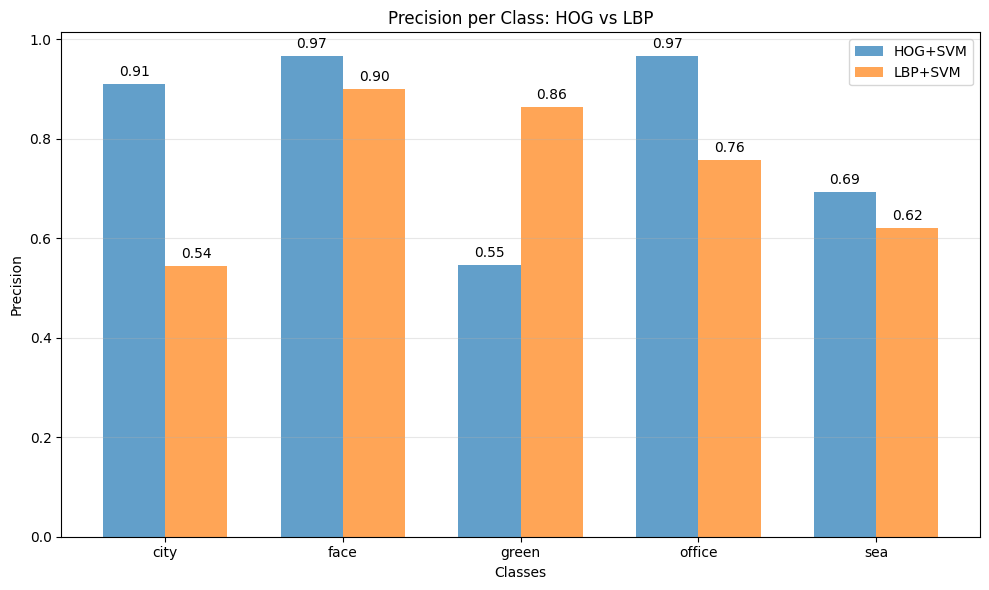


🔍 ANALYSIS: Which feature works better for each class?
--------------------------------------------------
city      : HOG is better by 0.366
            HOG=0.909, LBP=0.543
face      : HOG is better by 0.066
            HOG=0.966, LBP=0.900
green     : LBP is better by 0.318
            HOG=0.545, LBP=0.864
office    : HOG is better by 0.208
            HOG=0.966, LBP=0.758
sea       : HOG is better by 0.072
            HOG=0.692, LBP=0.621


In [ ]:
# =============================================================================
# SIMPLE CLASS-WISE PRECISION COMPARISON
# =============================================================================

def simple_classwise_precision_plot(hog_results, lbp_results, data_loader):
    """
    Simple bar plot comparing HOG vs LBP precision per class
    """
    
    # We'll calculate from confusion matrices
    from sklearn.metrics import precision_score
    
    # Get models
    hog_model = hog_results['model']
    lbp_model = lbp_results['model']
    
    # Make predictions
    y_pred_hog = hog_model.predict(X_test_hog)
    y_pred_lbp = lbp_model.predict(X_test_lbp)
    
    # Calculate precision per class
    hog_precision = precision_score(y_test, y_pred_hog, average=None)
    lbp_precision = precision_score(y_test, y_pred_lbp, average=None)
    
    # Create plot
    plt.figure(figsize=(10, 6))
    
    x = np.arange(len(data_loader.classes))
    width = 0.35
    
    plt.bar(x - width/2, hog_precision, width, label='HOG+SVM', alpha=0.7)
    plt.bar(x + width/2, lbp_precision, width, label='LBP+SVM', alpha=0.7)
    
    plt.xlabel('Classes')
    plt.ylabel('Precision')
    plt.title('Precision per Class: HOG vs LBP')
    plt.xticks(x, data_loader.classes)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add values on bars
    for i, v in enumerate(hog_precision):
        plt.text(i - width/2, v + 0.01, f'{v:.2f}', ha='center', va='bottom')
    for i, v in enumerate(lbp_precision):
        plt.text(i + width/2, v + 0.01, f'{v:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('../results/plots/precisionPerClass.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print analysis
    print("\n🔍 ANALYSIS: Which feature works better for each class?")
    print("-" * 50)
    
    for i, class_name in enumerate(data_loader.classes):
        if hog_precision[i] > lbp_precision[i]:
            better = "HOG"
            diff = hog_precision[i] - lbp_precision[i]
        else:
            better = "LBP"
            diff = lbp_precision[i] - hog_precision[i]
        
        print(f"{class_name:<10}: {better} is better by {diff:.3f}")
        print(f"            HOG={hog_precision[i]:.3f}, LBP={lbp_precision[i]:.3f}")

# Run it
simple_classwise_precision_plot(hog_results, lbp_results, data_loader)

In [16]:
# FINAL SUMMARY REPORT

print(f"\n{'='*70}")
print("🎉 PROJECT COMPLETED SUCCESSFULLY! - FINAL SUMMARY")
print(f"{'='*70}")

print(f"\n📊 DATASET SUMMARY:")
print(f"   - Training images: {X_train.shape[0]}")
print(f"   - Test images: {X_test.shape[0]}")
print(f"   - Classes: {data_loader.classes}")
print(f"   - Image size: {X_train[0].shape}")

print(f"\n🔧 FEATURE EXTRACTION SETTINGS:")
print(f"   - HOG orientations: {config.HOG_ORIENTATIONS}")
print(f"   - HOG pixels per cell: {config.HOG_PIXELS_PER_CELL}")
print(f"   - HOG cells per block: {config.HOG_CELLS_PER_BLOCK}")
print(f"   - LBP radius: {config.LBP_RADIUS}")
print(f"   - LBP points: {config.LBP_N_POINTS}")

print(f"\n🤖 MODEL SETTINGS:")
print(f"   - SVM kernel: {config.SVM_KERNEL}")
print(f"   - SVM C parameter: {config.SVM_C}")
print(f"   - Cross-validation folds: {config.K_FOLDS}")

print(f"\n📈 FINAL RESULTS:")
print(f"   - HOG + SVM Accuracy: {hog_results['accuracy']:.4f}")
print(f"   - LBP + SVM Accuracy: {lbp_results['accuracy']:.4f}")

if hog_results['accuracy'] > lbp_results['accuracy']:
    print(f"   - 🏆 HOG features performed better by {hog_results['accuracy'] - lbp_results['accuracy']:.4f}")
else:
    print(f"   - 🏆 LBP features performed better by {lbp_results['accuracy'] - hog_results['accuracy']:.4f}")

print(f"\n💾 SAVED FILES:")
print("   - hog_svm_model.pkl (Trained HOG+SVM model)")
print("   - lbp_svm_model.pkl (Trained LBP+SVM model)")
print("   - classification_results.pkl (All results and metrics)")
print("   - feature_visualization.png (Feature visualization)")

print(f"\n🚀 NEXT STEPS:")
print("   - Download the saved files from Colab")
print("   - Add them to your GitHub repository")
print("   - Update README.md with your results")
print("   - Consider experimenting with different parameters")


🎉 PROJECT COMPLETED SUCCESSFULLY! - FINAL SUMMARY

📊 DATASET SUMMARY:
   - Training images: 688
   - Test images: 150
   - Classes: ['city', 'face', 'green', 'office', 'sea']
   - Image size: (128, 128, 3)

🔧 FEATURE EXTRACTION SETTINGS:
   - HOG orientations: 9
   - HOG pixels per cell: (8, 8)
   - HOG cells per block: (2, 2)
   - LBP radius: 3
   - LBP points: 24

🤖 MODEL SETTINGS:
   - SVM kernel: rbf
   - SVM C parameter: 1.0
   - Cross-validation folds: 5

📈 FINAL RESULTS:
   - HOG + SVM Accuracy: 0.7867
   - LBP + SVM Accuracy: 0.7000
   - 🏆 HOG features performed better by 0.0867

💾 SAVED FILES:
   - hog_svm_model.pkl (Trained HOG+SVM model)
   - lbp_svm_model.pkl (Trained LBP+SVM model)
   - classification_results.pkl (All results and metrics)
   - feature_visualization.png (Feature visualization)

🚀 NEXT STEPS:
   - Download the saved files from Colab
   - Add them to your GitHub repository
   - Update README.md with your results
   - Consider experimenting with different par